In [32]:
#import pygame
#palette=pygame.colordict.THECOLORS
import cv2
import wget
from color_util import *
from color_cluster import* 
from skimage.color import rgb2lab, deltaE_cie76,lab2rgb
from skimage import io
import numpy as np
import pandas as pd
import time
palette=pd.read_csv("rgb.txt",header=0,sep='#')
for index, row in palette.iterrows():
    row['colorname']=row['colorname'][:-1]
    row['hexcode']='#'+row['hexcode'][:-1]

In [49]:
hexcode=palette['hexcode']
colorname=palette['colorname']

In [34]:
def hex2rgb(hexcode):
    h= hexcode.lstrip('#')
    return np.array([int(h[i:i+2], 16) for i in (0, 2, 4)],dtype='uint8')

In [35]:
rgb2lab(hex2rgb(hexcode[0])).shape

(3,)

In [51]:
hexcode_lab=np.empty((0,3),dtype='uint8')
for p in hexcode:
    p_lab=(rgb2lab(hex2rgb(p))).reshape((1,3))
    hexcode_lab=np.append(hexcode_lab,p_lab,axis=0)

In [36]:
pat_time=pd.read_csv("pat_time_nyc_all.csv",sep=",",header=0)

In [37]:
pop_color=pd.read_csv("pattern_nyc_pop_color_all.csv",header=0,sep="^")

In [43]:
pop_color.fillna(value=0,inplace=True)

In [44]:
dat=pat_time.merge(pop_color,how='inner',on="pattern_id")

In [287]:
#dat=dat.drop(columns=['Unnamed: 0_x','Unnamed: 0_y','Unnamed: 0.1'])

In [45]:
keep=['time']
keep.extend([str(i) for i in range(949)])
dat_time=dat[keep]

In [46]:
dat_time=dat_time.groupby('time').sum()

In [482]:
#dat_time

In [304]:
start=pd.to_datetime('2015/12')
end=pd.to_datetime('2020/1')
x=dat_time[pd.to_datetime(dat_time.index)>start].copy()
x=x[pd.to_datetime(x.index)<end]


In [306]:
x['tot']=x.sum(axis=1)

In [38]:
colorcode=pd.read_excel("NewMicrosoftExcelWorksheet.xlsx")

In [39]:
colorcode=colorcode.rename(columns={'Hex Equivalent':'colorname','Unnamed: 1':'hexcode'})
colorcode.iloc[8]["hexcode"]='#F0F8FF'

In [40]:
color_136=np.empty((136,3))
for i in range(136):
    color_136[i]=hex2rgb(colorcode['hexcode'][i])
color_136=color_136.astype('uint8')

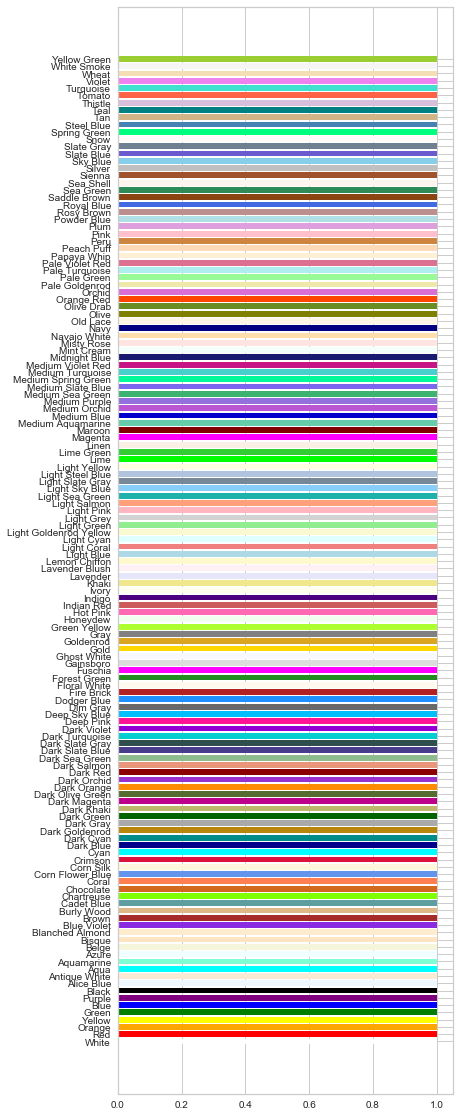

In [10]:
fig, ax = plt.subplots(figsize=(6,20))
ax.barh(range(136),np.ones(136),color=color_136/255.)
plt.yticks(ticks=range(136),labels=colorcode['colorname'])
plt.show()

In [ ]:
rgb2lab(color_136)

In [52]:
color_949_to_136=[]
for i in range(949):
    color_949_to_136.append(
        np.argmin(deltaE_cie76(hexcode_lab[i],rgb2lab(color_136))))

In [53]:
colorcode.iloc[color_949_to_136[0]]


colorname    Light Steel Blue
hexcode               #B0C4DE
Name: 78, dtype: object

In [54]:
column=['time']
column.extend([i for i in range(136)])
color_time_136=pd.DataFrame(columns=column)
color_time_136['time']=dat_time.index
color_time_136.fillna(value=0,inplace=True)

for i in range(136):
    for j in range(949):
        if color_949_to_136[j]==i:
           # print(j,i)
            color_time_136[i]=np.asarray(color_time_136[i])+np.asarray(dat_time[str(j)])

In [55]:
color_time_136['tot']=color_time_136.iloc[:, 1:].sum(axis=1)


(0, 0.16)

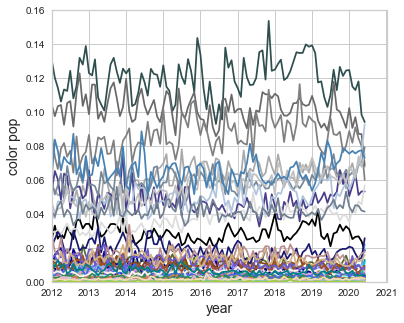

In [91]:
#color_time_136
import matplotlib.pyplot  as plt
import matplotlib.dates as mdates
x=color_time_136.copy()
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(pd.to_datetime(x['time']),x[0]/x['tot'],ls=':')#c=colorcode['hexcode'][c])
for c in range(1,136):
    ax.plot(pd.to_datetime(x['time']),x[c]/x['tot'],c=colorcode['hexcode'][c])

datemin = np.datetime64('2012')
datemax = np.datetime64('2021')
ax.set_xlim(datemin,datemax)
years = mdates.YearLocator()
ax.xaxis.set_major_locator(years)

ax.set_xlabel('year',fontsize=14)
ax.set_ylabel('color pop',fontsize=14)
ax.set_ylim(0,0.16)

(0, 0.01)

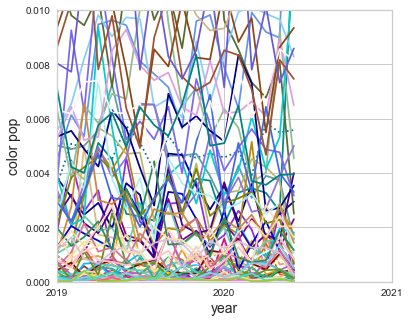

In [61]:
x=color_time_136.copy()
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(pd.to_datetime(x['time']),x[0]/x['tot'],ls=':')#c=colorcode['hexcode'][c])
for c in range(1,136):
    ax.plot(pd.to_datetime(x['time']),x[c]/x['tot'],c=colorcode['hexcode'][c])

datemin = np.datetime64('2019')
datemax = np.datetime64('2021')
ax.set_xlim(datemin,datemax)
years = mdates.YearLocator()
ax.xaxis.set_major_locator(years)

ax.set_xlabel('year',fontsize=14)
ax.set_ylabel('color pop',fontsize=14)
ax.set_ylim(0,0.01)

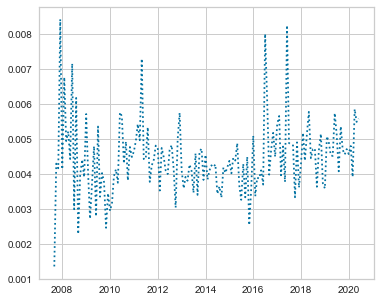

In [64]:
#white
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(pd.to_datetime(x['time']),x[0]/x['tot'],ls=':')

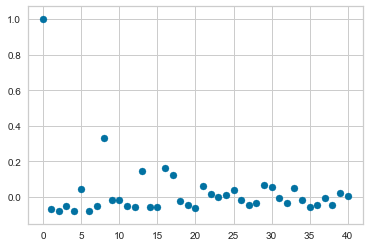

In [90]:
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
pcf= pacf(x[35]/x['tot'])
af=acf(x[35]/x['tot'])
#plt.scatter(range(41),pcf)
plt.scatter(range(41),af)

In [483]:
x.to_csv("color_pop_time_nyc_pattern_all.csv")

In [250]:
image_id=748148
image=cv2.imread(str(image_id)+'.jpg')
def image_pop_color(image,image_id):

    image=prepare_image(image).astype('uint8')
    image_lab=rgb2lab(image)
    num_pix=image.shape[0]
    image_color_index=[]

    start_time=time.time()
    for i in range(num_pix):
        image_color_index.append(
            np.argmin(deltaE_cie76(image_lab[i],hexcode_lab)))

    (unique, counts)=np.unique(image_color_index, return_counts=True)
    frequency={u:c for(u,c) in zip(unique, counts)}
    frequency['pattern_id']=image_id
    end_time=time.time()
    print('time',end_time-start_time)
    return frequency

In [22]:
#f=image_pop_color(image,image_id)
forecast=pd.read_csv("color_pop_forecast_c0.csv")

In [21]:
forecast=pd.read_csv("color_pop_forecast_c0.csv")

In [24]:
x=pd.read_csv("color_pop_time_nyc_pattern_all.csv")

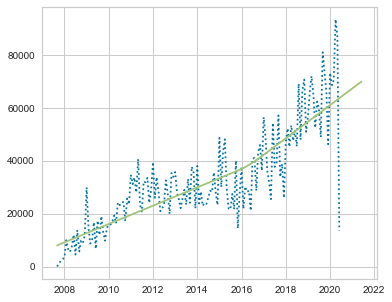

In [30]:
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(pd.to_datetime(x['time']),x['0'],ls=':')
ax.plot(pd.to_datetime(forecast['ds']), forecast['trend'])

In [28]:
forecast.columns

Index(['Unnamed: 0', 'ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower',
       'trend_upper', 'additive_terms', 'additive_terms_lower',
       'additive_terms_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')